In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Step 1: Install Necessary Libraries
# Ensure all necessary libraries are installed
!pip install transformers torch datasets scikit-learn matplotlib tqdm


In [ ]:
# Step 2: Import Required Libraries
from transformers import T5Tokenizer, T5ForConditionalGeneration
from torch.utils.data import DataLoader, Dataset
import torch
import json
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data_path, tokenizer, max_length=512):
        self.data = self.load_data(data_path)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def load_data(self, file_path):
        with open(file_path, 'r') as f:
            return json.load(f)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        input_text = item.get('Text', '')
        text_logic_form = item.get('Text_Logic_Forms', {}).get('Predicates', [])
        diagram_logic_form = item.get('Diagram_Logic_Forms', {}).get('Predicates', [])

        # Convert logic_form into a single string if it's a list
        text_logic_form = ' '.join(text_logic_form) if isinstance(text_logic_form, list) else text_logic_form
        diagram_logic_form = ' '.join(diagram_logic_form) if isinstance(diagram_logic_form, list) else diagram_logic_form

        # Tokenize inputs
        inputs = self.tokenizer(
            input_text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        # Tokenize text labels (text logic form)
        text_labels = self.tokenizer(
            text_logic_form,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        # Tokenize diagram labels (diagram logic form)
        diagram_labels = self.tokenizer(
            diagram_logic_form,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        # Return both text and diagram labels
        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'text_labels': text_labels['input_ids'].squeeze(0),
            'diagram_labels': diagram_labels['input_ids'].squeeze(0)
        }

In [ ]:
# Step 4: Initialize Tokenizer and Model
max_length = 256  # Reduce the maximum length
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-small")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-small")


train_dataset = CustomDataset(
    data_path="/kaggle/input/llava-dataset/Llava/updatedID_train_data_final.json",
    #embeddings_path="/kaggle/input/llava-dataset/Llava/train_diagram_embeddings.json",
    tokenizer=tokenizer
)

test_dataset = CustomDataset(
    data_path="/kaggle/input/llava-dataset/Llava/updatedID_test_data_final.json",
    #embeddings_path="/kaggle/input/llava-dataset/Llava/test_diagram_embeddings.json",
    tokenizer=tokenizer
)


train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [ ]:
# Update your training loop to handle both text and diagram labels
def train_model(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        text_labels = batch['text_labels'].to(device)
        diagram_labels = batch['diagram_labels'].to(device)

        # You might need to concatenate or handle the two labels in a certain way
        labels = torch.cat((text_labels, diagram_labels), dim=1)  # Concatenate if needed

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)


In [ ]:
# Also, modify the evaluation function to handle both labels:
def evaluate_model(model, test_loader, tokenizer, device):
    model.eval()
    predictions, targets = [], []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            text_labels = batch['text_labels'].to(device)
            diagram_labels = batch['diagram_labels'].to(device)

            outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask)

            # Decode both sets of predictions
            text_preds = [tokenizer.decode(ids, skip_special_tokens=True) for ids in outputs]
            diagram_preds = [tokenizer.decode(ids, skip_special_tokens=True) for ids in outputs]

            # Assuming we want to combine both for evaluation
            predictions.extend(text_preds)
            predictions.extend(diagram_preds)

            text_targs = [tokenizer.decode(ids, skip_special_tokens=True) for ids in text_labels]
            diagram_targs = [tokenizer.decode(ids, skip_special_tokens=True) for ids in diagram_labels]

            targets.extend(text_targs)
            targets.extend(diagram_targs)

    accuracy = accuracy_score(targets, predictions)
    return accuracy, predictions, targets


In [ ]:
# Step 8: Initialize Optimizer and Criterion
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print if running on GPU or CPU
if torch.cuda.is_available():
    print("Running on GPU")
else:
    print("Running on CPU")

# Move model to the appropriate device
model.to(device)

# Step 9: Train and Evaluate the Model
epochs = 5
train_losses = []
test_accuracies = []

print("Starting training...")

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs} - Training...")

    # Train the model and get the train loss
    train_loss = train_model(model, train_loader, optimizer, None, device)
    print(f"Train Loss for Epoch {epoch + 1}: {train_loss:.4f}")

    # Evaluate the model and get the accuracy
    accuracy, _, _ = evaluate_model(model, test_loader, tokenizer, device)
    print(f"Test Accuracy for Epoch {epoch + 1}: {accuracy:.4f}")

    # Append results to lists
    train_losses.append(train_loss)
    test_accuracies.append(accuracy)

    # Print the current epoch's progress
    print(f"Epoch {epoch + 1} complete.")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

print("Training complete.")



Running on GPU
Starting training...
Epoch 1/5 - Training...
Train Loss for Epoch 1: 0.1602


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Test Accuracy for Epoch 1: 0.1568
Epoch 1 complete.
Train Loss: 0.1602
Test Accuracy: 0.1568
Epoch 2/5 - Training...
Train Loss for Epoch 2: 0.1087


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Test Accuracy for Epoch 2: 0.1914
Epoch 2 complete.
Train Loss: 0.1087
Test Accuracy: 0.1914
Epoch 3/5 - Training...
Train Loss for Epoch 3: 0.0946


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Test Accuracy for Epoch 3: 0.2013
Epoch 3 complete.
Train Loss: 0.0946
Test Accuracy: 0.2013
Epoch 4/5 - Training...
Train Loss for Epoch 4: 0.0865


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Test Accuracy for Epoch 4: 0.2030
Epoch 4 complete.
Train Loss: 0.0865
Test Accuracy: 0.2030
Epoch 5/5 - Training...
Train Loss for Epoch 5: 0.0811


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Test Accuracy for Epoch 5: 0.2178
Epoch 5 complete.
Train Loss: 0.0811
Test Accuracy: 0.2178
Training complete.


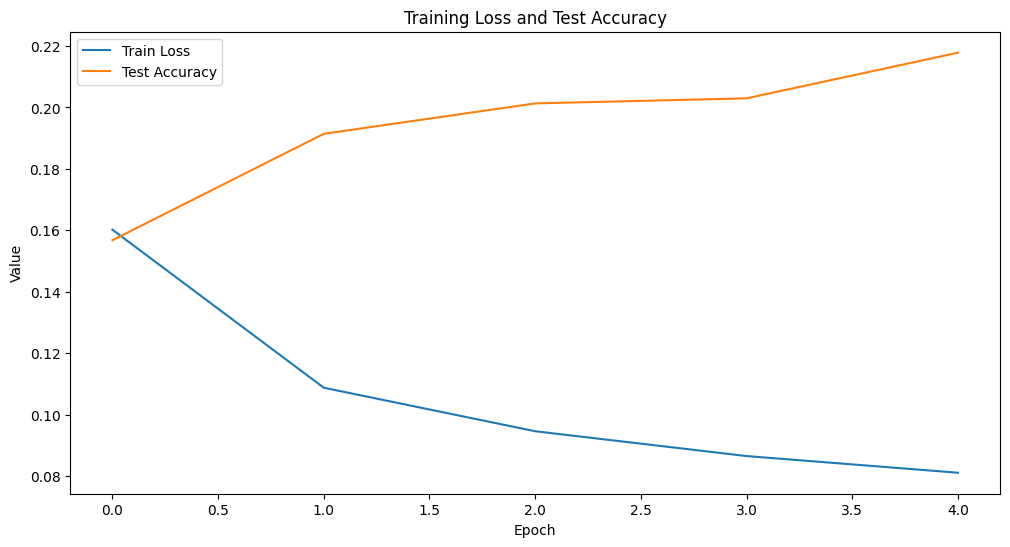

In [ ]:
# Step 10: Visualize Results
plt.figure(figsize=(12, 6))
plt.plot(range(epochs), train_losses, label="Train Loss")
plt.plot(range(epochs), test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training Loss and Test Accuracy")
plt.legend()
plt.show()

In [ ]:
import torch
import json
import os